In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today()
from matplotlib.ticker import ScalarFormatter

In [4]:
def Black_Scholes_price(S, K, T, r, q, sigma, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * q * np.exp(-q * T) * norm.cdf(d2) 
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)
    
    return option_price, delta, gamma, theta, vega

In [6]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [146]:
def find_arbitrage(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    expiration = ticker.options[1]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    calls = option_chain.calls
    #calls = All_calls[ (All_calls['openInterest'] >= 50 )]
    puts = option_chain.puts
    #puts = All_puts[All_puts['openInterest'] >= 50]

    calls['contractType'] = "call"
    puts['contractType'] = "put"
    
    current_price = ticker.info['currentPrice']
    calls['underlying'] = current_price
    puts['underlying'] = current_price
    dividends = ticker.dividends.iloc[-1] if not ticker.dividends.empty else 0
    
    risk_free_rate = Get_rfr()
    for df in [calls, puts]:
        df['TheoreticalPrice'],df['delta'],df['gamma'],df['theta'],df['vega'] = np.where(
            (df['openInterest'] > 50),
            Black_Scholes_price(current_price, df['strike'], (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365,
                                        risk_free_rate, dividends, df['impliedVolatility'], df['contractType'].iloc[0]),
            np.nan
        )
    '''
    ------------------------------------------------------------------------------------------------------------------------------------
    Buy low ask, sell high bid
    ------------------------------------------------------------------------------------------------------------------------------------
    '''
    
    calls['Discrepancy_buy'] = (calls['ask'] - calls['TheoreticalPrice'])
    calls['Discrepancy_sell'] = (calls['bid'] - calls['TheoreticalPrice'])
    calls = calls[ (calls['openInterest'] >= 500 ) & (calls['strike'] <= calls['underlying']*2 )] # must be high in interest and strike no too wild
    
    puts['Discrepancy_buy'] = (puts['ask'] - puts['TheoreticalPrice'])
    puts['Discrepancy_sell'] = (puts['bid'] - puts['TheoreticalPrice'])
    puts = puts[ (puts['openInterest'] >= 500 ) & (puts['strike'] <= puts['underlying']*2 )]

    Option_price_threshold = 0.05 # % difference
    price_ticker_size = 0.01 #USD
    #Collect all under price and over price options

    #Condition: Discrepancy > 0 (for long) or Discrepancy < 0(for short) threshold, Discrepancy > ticker_szie, bid > 0(for long) or bit > 0(for short)
    buy_list = pd.concat([ calls[(calls['Discrepancy_buy'] < Option_price_threshold*calls['TheoreticalPrice']) & (calls['Discrepancy_buy'] > price_ticker_size) & (calls['Discrepancy_buy'] > calls['Discrepancy_sell'])],
                          puts[(puts['Discrepancy_buy'] < Option_price_threshold*puts['TheoreticalPrice']) & (puts['Discrepancy_buy'] > price_ticker_size) & (puts['Discrepancy_buy'] > puts['Discrepancy_sell'])] ],
                         ignore_index=True, sort=False)
    sell_list = pd.concat([calls[ (calls['Discrepancy_sell'] > Option_price_threshold*calls['TheoreticalPrice'])  & (calls['bid']>0) & (calls['Discrepancy_sell'] > calls['Discrepancy_buy'])],
                           puts[(puts['Discrepancy_sell'] > Option_price_threshold*puts['TheoreticalPrice'])  & (puts['bid']>0) & (puts['Discrepancy_sell'] > puts['Discrepancy_buy']) ] ],
                          ignore_index=True, sort=False)
    buy_list['sign'] = +1
    sell_list['sign'] = -1
    print(f'The current price for {ticker_symbol} is {current_price},')
    print(f"Found {len(buy_list)} potential long arbitrage opportunities")
    print(f"Found {len(sell_list)} potential short arbitrage opportunities")
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.scatter(buy_list['strike'], buy_list['Discrepancy_buy'], label='Long', alpha=0.5)
    plt.scatter(sell_list['strike'], sell_list['Discrepancy_sell'], label='Short', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axvline(x=current_price, color='g', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Discrepancy ($)')
    plt.title(f'Option price discrepancy for {ticker_symbol}')
    plt.legend()
    plt.show()
    
    return buy_list, sell_list

The current price for NVDA is 135.4,
Found 96 potential long arbitrage opportunities
Found 0 potential short arbitrage opportunities


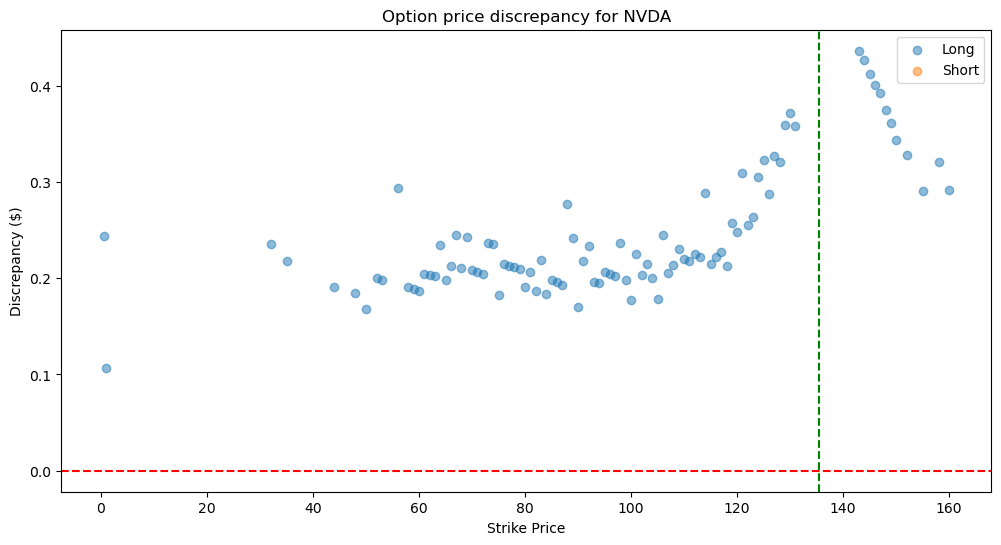


Top 5 long Arbitrage Opportunities:
----------------------------------------
         contractSymbol             lastTradeDate  strike  lastPrice    bid  \
84  NVDA241115P00143000 2024-11-01 19:48:36+00:00   143.0       9.60   9.50   
85  NVDA241115P00144000 2024-11-01 19:28:06+00:00   144.0      10.05  10.25   
86  NVDA241115P00145000 2024-11-01 19:57:21+00:00   145.0      11.18  11.00   

      ask    change  percentChange  volume  openInterest  ...  contractType  \
84   9.70 -1.500000     -13.513513   364.0        4120.0  ...           put   
85  10.45 -2.400000     -19.277105    52.0        2699.0  ...           put   
86  11.20 -1.969999     -14.980984   268.0        4496.0  ...           put   

    underlying TheoreticalPrice     delta     gamma      theta      vega  \
84       135.4         9.263791 -0.724850  0.029484 -57.458211  8.191368   
85       135.4        10.023814 -0.752222  0.027968 -54.388528  7.762074   
86       135.4        10.787635 -0.779566  0.026410 -50.5974

In [148]:
Stock = "NVDA"
long_list, short_list = find_arbitrage(Stock)
all_options = pd.concat([long_list,short_list])

# Display the top 5 arbitrage opportunities for calls and puts
print("\nTop 5 long Arbitrage Opportunities:")
print('----------------------------------------')
print(long_list.sort_values('Discrepancy_buy', ascending=False).head(3))
print("=======================================================================================")
print("\nTop 5 short Arbitrage Opportunities:")
print('-----------------------------------------')
print(short_list.sort_values('Discrepancy_sell', ascending=False).head(3))

In [150]:
#Instant Delta hedging:
def Create_Delta_hedging(options):
    if options.empty:
        print("No arbitrage found")
        return pd.DataFrame()
    
    portfolio = options.copy()
    
    portfolio['share volume'] = portfolio['delta']
    portfolio['share volume'] = portfolio['share volume'].where(portfolio['share volume'] >= 1, 0) # please at least buy one share thx
    
    portfolio['stock invested'] = portfolio['share volume'] * portfolio['underlying']

    
    portfolio['cash flow'] = portfolio['sign'] * portfolio['lastPrice'] * portfolio['volume']
    
    return portfolio

Pi = Create_Delta_hedging(all_options)

In [152]:
Total_cash_flow = Pi['cash flow'].sum() if not Pi.empty else 0
Require_stock = Pi['stock invested'].sum() if not Pi.empty else 0
print(f'Total cash flow is {Total_cash_flow:.3e} USD')
print(f'Inversted stock worth {Require_stock:.3e} USD')
print(f'Cash flow to required cash ratio: {Total_cash_flow/Require_stock*100:.3f}%') if Require_stock != 0 else print("No arbitrage")

Total cash flow is 2.910e+05 USD
Inversted stock worth 1.354e+02 USD
Cash flow to required cash ratio: 214930.657%


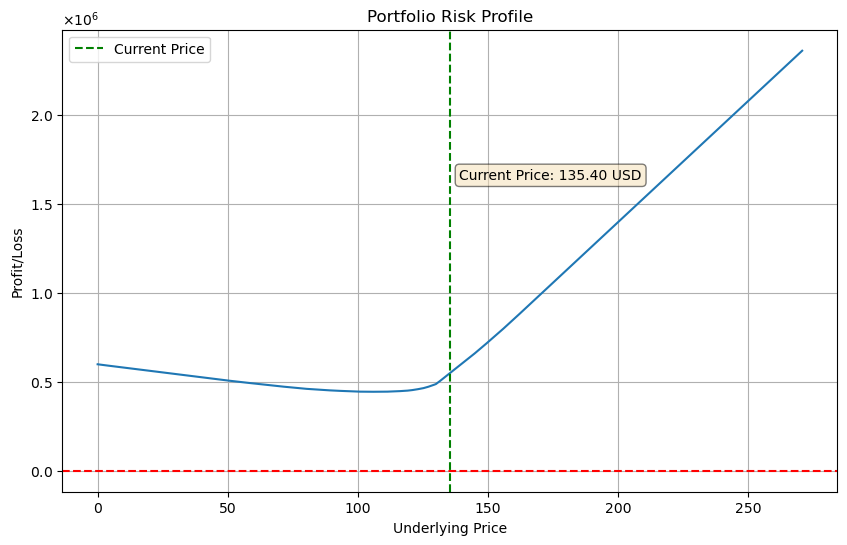

Minimum profit (or maximum loss) is 4.444e+05 USD from initial cost 1.354e+02 USD (could be worse, look at the graph)
Minimum profit (or maximum loss) %: 328195.78%


In [154]:
def Portfolio_risk(portfolio):
    if portfolio.empty:
        print("No arbitrage, no profit, not risk")
        return pd.DataFrame()
    base_price = portfolio["underlying"].iloc[0]
    grid_size = 2**11
    possible_prices = np.linspace(0, base_price*2, grid_size)
    Profits = np.zeros(len(possible_prices))

    initial_stock_invested = portfolio['stock invested'].sum()
    
    for i, price in enumerate(possible_prices):
        
        call_profit = portfolio[portfolio['contractType'] == 'call']['volume'] * \
                      np.maximum(price - portfolio[portfolio['contractType'] == 'call']['strike'], 0)
        
        put_profit = portfolio[portfolio['contractType'] == 'put']['volume'] * \
                     np.maximum(portfolio[portfolio['contractType'] == 'put']['strike'] - price, 0)
        
        Profits[i] = (call_profit.sum() + put_profit.sum() + #Profit from options
                      portfolio['cash flow'].sum() + #Profit from option arbitrage (Could be negative if we spend a lot in buying options)
                      price * portfolio['share volume'].sum() - #Stock worth
                      initial_stock_invested) # intial stock invested


#--------------------------------------------------------------------------------------------------------------------------------------
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(possible_prices, Profits)
    plt.title('Portfolio Risk Profile')
    plt.xlabel('Underlying Price')
    plt.ylabel('Profit/Loss')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axvline(x=base_price, color='g', linestyle='--', label='Current Price')
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.63, 0.7, f'Current Price: {base_price:.2f} USD', transform=plt.gca().transAxes, verticalalignment='top', horizontalalignment='center', bbox=props)
    plt.legend()
    plt.grid(True)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.show()
    
    print(f'Minimum profit (or maximum loss) is {min(Profits):.3e} USD from initial cost {initial_stock_invested:.3e} USD (could be worse, look at the graph)')
    if initial_stock_invested > 0:
        min_profit_percentage = min(Profits) / initial_stock_invested * 100
        print(f'Minimum profit (or maximum loss) %: {min_profit_percentage:.2f}%')
    elif initial_stock_invested < 0:
        max_profit_percentage = min(Profits) / abs(initial_stock_invested) * 100
        print(f'Maximum profit %: {max_profit_percentage:.2f}%')
    else:
        print('Initial cost is zero. Cannot calculate percentage profit/loss.')
#--------------------------------------------------------------------------------------------------------------------------------------
    
Portfolio_risk(Pi)